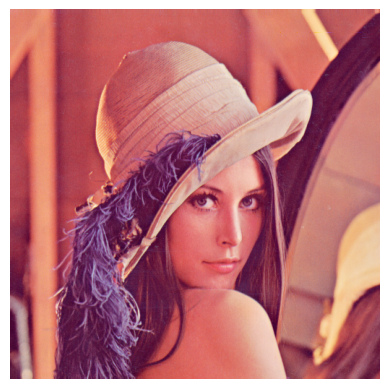

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import cv2
import math

# Defining quantization matrixes
quantization_matrix_y = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61],
                                [ 12, 12, 14, 19, 26, 28, 60, 55 ],
                                [ 14, 13, 16, 24, 40, 57, 69, 56 ],
                                [ 14, 17, 22, 29, 51, 87, 80, 62 ],
                                [ 18, 22, 37, 56, 68, 109, 103, 77 ],
                                [ 24, 35, 55, 64, 81, 104, 113, 92 ],
                                [ 49, 64, 78, 87, 103, 121, 120, 101 ],
                                [ 72, 92, 95, 98, 112, 100, 103, 99 ]]
                                )


quantization_matrix_c = np.array([[17,18,24,47,99,99,99,99],
                         [18,21,26,66,99,99,99,99],
                         [24,26,56,99,99,99,99,99],
                         [47,66,99,99,99,99,99,99],
                         [99,99,99,99,99,99,99,99],
                         [99,99,99,99,99,99,99,99],
                         [99,99,99,99,99,99,99,99],
                         [99,99,99,99,99,99,99,99]])

quantization_matrix_y=(quantization_matrix_y*2)
#quantization_matrix_y=(quantization_matrix_c*2)
Q = [quantization_matrix_y,quantization_matrix_c,quantization_matrix_c]

block_size = 8
channels=3
marvin = plt.imread('Lenna.png')
marvin = np.uint8(np.array(marvin)*255)# from color map to rgb
plt.axis('off')
plt.imshow(marvin)

In [2]:
# conversion from rgb to YCBCR
def rgb_to_Ycbcr(image):
    
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = image.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)
# conversion from YCBCR to rgb
def ycbcr_to_rgb(image):
    
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = image.astype(float)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)



# plotting data for different channels
def plot_ycbcr(image_to_plot):
    titles = ["Y","CB","CR"]
    plt.figure(figsize=(20,20))
    for channel in range(3):
        plt.subplot(3, 3,channel + 1 )
        plt.axis('off')
        plt.title(titles[channel])
        chroma = image_to_plot.copy()
        channels = [0,1,2]
        channels.remove(channel)
        chroma[:,:,channels] =   255/2
        rgb_im = ycbcr_to_rgb(chroma)
        plt.imshow( rgb_im )         

# Zig Zag crossing take an 8x8 matrix return an array
def zigzag(matrix):
    
    i = 0
    j = 0
    imin = 0
    jmin = 0
    imax = 8
    jmax = 8
    index = 0
    output = np.zeros(imax*jmax)

    while i < imax and j < jmax:
    
        if (i+j) % 2 == 0 :

            if i == imin :
                output[index] = matrix[i,j]
                j = j + 1

            elif (i != imin or i == imax - 1) and ( j != jmax -1 ):
                output[index] = matrix[i,j]
                i = i - 1 
                j = j + 1

            elif j == jmax - 1:
                output[index] = matrix[i,j] 
                i = i + 1
        else :

            if i == imin :
                output[index] = matrix[ i,j ]
                i = i + 1
                j = j - 1
            
            elif j == jmin and i != imax - 1 :
                output[index] = matrix[i,j]
                i = i + 1
            
            elif i == imax - 1 :
                output[index] = matrix[ i,j ]
                j = j + 1

            else :
                output[index] = matrix[i,j]
                i = i + 1
                j = j - 1
        
        index += 1

        if i == imax - 1 and j == jmax - 1 :
            output[index] = matrix[i,j]
            break
        
    return output

# Inverse Zig Zag take an array of 16 elements return a 8x8 matrix
def inverseZigZag(data):
    
    i = 0 
    j = 0 
    
    imax = 8
    jmax = 8
    
    imin = 0
    jmin = 0
    
    index = 0
    
    matrix = np.zeros((jmax,jmax))
    
    while i < imax and j < jmax :

        if (i + j )% 2 == 0:
            
            if i == imin: 
                matrix[i,j] = data[index]
                j = j+1
            
            elif (i != imin or i == imax -1) and ( j != jmax - 1 ):
                matrix[i,j] = data[index]
                i = i - 1
                j = j + 1
            
            elif j == jmax - 1:
                matrix[i,j] = data[index]
                i = i + 1
            
        else :
            
            if i == imin :
                matrix[i,j] = data[index]
                i = i + 1
                j = j - 1
                
            elif j == jmin and i != imax - 1 :
                matrix[i,j] = data[index]
                i = i + 1
            
            elif i == imax - 1:
                matrix[i,j] = data[index]
                j = j + 1
                
            else :
                matrix[i,j] = data[index]
                i = i + 1
                j = j - 1
                
        index +=1  
        
        if ( i == imax -1 ) and ( j == jmax - 1 ):
            matrix[i,j] = data[index]
            break
            
    return matrix 

In [3]:
def required_bits(elem):
    elem = abs(elem)
    result = 0
    while elem > 0:
        elem >>= 1
        result += 1
    return result

def uint_to_bin(data,size):
    return bin(data)[2:][-size:].zfill(size)

def binstr_flip(bin_data):
    # check if binstr is a binary string
    if not set(bin_data).issubset('01'):
        raise ValueError("binstr should have only '0's and '1's")
    return ''.join(map(lambda c: '0' if c == '1' else '1', bin_data))

def int_to_bin(data):
    if data == 0:
        return ''

    binstr = bin(abs(data))[2:]

    # change every 0 to 1 and vice verse when n is negative
    return binstr if data > 0 else binstr_flip(binstr)
    
def flatten(lst):
    return [item for sublist in lst for item in sublist]

def modified_run_length(data):
    skip = 0
    symbols = []
    values = []
    nonzero = -1
    skip = 0
    
    for i,elem in enumerate(data):
        if elem != 0 :
            nonzero = i
    
    for i,elem in enumerate(data):
        if i > nonzero:
            symbols.append((0,0))
            values.append(int_to_bin(0))
            break
        
        elif elem == 0 and skip < 15:
            skip+=1
        
        else:
            size = required_bits(elem)
            symbols.append( (skip,size) )
            values.append( int_to_bin(elem))
            skip = 0
            
    return symbols,values

In [4]:
# The Huffman Encoding process

# Class for a node of the tree 
# we have the symbol of the node 
# his left node and right node 
# the frequency of the node 
class HuffmanNode:
    
    def __init__( self ,probability ,symbol ,left = None , right = None ):
        self.probability = probability
        self.symbol = symbol
        self.left = left
        self.right = right
        self.code = ""

# Given the data (an array) we estimate 
# the frequency of each of our symbols
# return a dictionary with the symbol and 
# his frequency
def probabEstimate(data):
    local_symbol = dict()
    #data=list(data)
    for elem in data :
        if local_symbol.get(elem) == None:
            local_symbol[elem] = 1
        else :
            local_symbol[elem] += 1
    #print(local_symbol)
    return local_symbol

codes = dict()

# we get the code used for a specific symbol
# takes a node as input and crosses the Huffman 
# tree until it dosen't get the leaf
def getCodes(node,value = ""):
        
    new_val = value + str(node.code) 
        
    if node.left:
        getCodes(node.left,new_val)
        
    if node.right:
        getCodes(node.right,new_val)
        
    if not node.right and not node.left :
        codes[node.symbol] = new_val
        
    return codes

# given the input data perform the Huffman encoding 
# and return a byte array and the Huffman tree
def huffmanEncoding(data):
    #data = list(data) # converting input data into array
    frequency_data = probabEstimate(data)
    symbols = frequency_data.keys()
    frequencies = frequency_data.values()
    nodes = []

    father = 0
    
    for elem in symbols:
        nodes.append( HuffmanNode( frequency_data.get(elem),elem ) )
                     
    while len(nodes) > 1 :
        father = 0
        nodes = sorted( nodes, key = lambda  x : x.probability  )
        
        right = nodes[0]
        left = nodes[1]
        
        left.code = 0
        right.code = 1
        new_node = HuffmanNode( left.probability + right.probability ,str(father) + "root"  , left , right )
        father+=1
        nodes.remove(left)
        nodes.remove(right)
        nodes.append(new_node)

    encoding = getCodes( nodes[0] )

    
    return encoding,nodes[0]

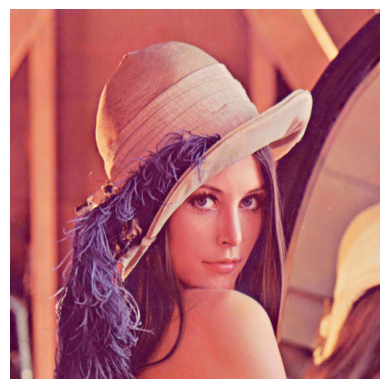

In [5]:
marvin_ycbcr = rgb_to_Ycbcr(marvin)
# Downsampling image for chrominance
down_image = marvin_ycbcr
#print(down_image[:3,:3,2])
down_image[:,:,1] = 10*np.round(down_image[:,:,1]/10)
down_image[:,:,2] = 10*np.round( down_image[:,:,2]/10 )
#print(down_image[:3,:3,2])
down_image = ycbcr_to_rgb(down_image)
plt.axis('off')
plt.imshow(down_image)

4096


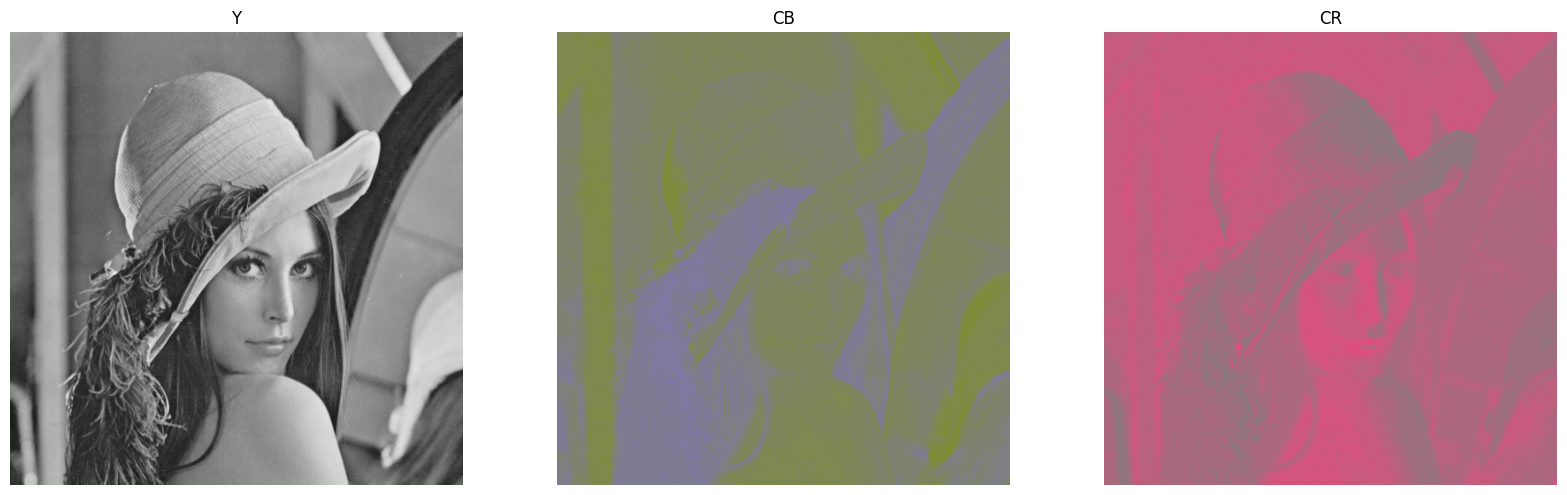

In [17]:
plot_ycbcr(marvin_ycbcr)

# Number of block we need
[h,w,i] = marvin_ycbcr.shape
num_blocks_h = math.ceil( h / block_size )
num_blocks_w = math.ceil( w / block_size )

# Create a padded image (and make it dividable by 8)
if num_blocks_h%8 == num_blocks_w%8 == 0:
    size = h //8 *w //8

H = block_size * h if h%8!=0 else h
W = block_size * w if w%8!=0 else w
padded_image = np.zeros((H,W,3))
padded_image[:h,:w] = marvin_ycbcr[:h,:w]
data_compressed = np.zeros(H*W*3) 
index = 0
print(size)
dc_component = np.empty((size,3),dtype=np.int32)
ac_component = np.empty((size,63,3),dtype=np.int32)

In [18]:
# Encoding process
for channel in range (channels):
    current_block = "n/a"
    block_index = 0
    for index1 in range (num_blocks_h):
        row_begin = index1 * block_size
        row_end = row_begin + block_size

        for index2 in range (num_blocks_w):
            
            column_begin = index2 * block_size
            column_end = column_begin + block_size

            block = padded_image[ row_begin:row_end,column_begin:column_end,channel] # 8x8 block
            # We apply the DCT to each block
            DCT_block = cv2.dct(block)
            # We divide by the quantization matrix
            DCT_normalized = np.divide( DCT_block,Q[channel] ).astype(int)
            resulting_block = zigzag(DCT_normalized)
            if(block_index == 0):
                dc_component[block_index,channel] = resulting_block[0]   
                ac_component[block_index,:,channel] = resulting_block[1:]
            else:
                dc_component[block_index,channel] = resulting_block[0] - previous_block   
                ac_component[block_index,:,channel] = resulting_block[1:]
            
            previous_block=resulting_block[0]
            block_index += 1
            data_compressed[index : index + 64 ] = resulting_block
            index += 64
            #resulting_block = np.reshape(resulting_block,(block_size,block_size) )
            #padded_image[row_begin:row_end,column_begin:column_end,channel] = resulting_block
            

print(padded_image.shape,dc_component.shape,ac_component.shape)
dc_component[0,1]

(512, 512, 3) (4096, 3) (4096, 63, 3)


49

In [19]:
# Huffman tree operation
data_dc_Y = {}
data_dc_C = {}
data_ac_Y = {}
data_ac_C = {}
ac_elem_Y = []
ac_elem_C = []
print(dc_component.shape,ac_component.shape)
for j in range(channel):
    for i in range(size):
        
        if j == 0:
            ac_elem_Y.append(modified_run_length(ac_component[i,:,0])[0] )
            
        ac_elem_C.append( modified_run_length(ac_component[i,:,j])[0])


# Huffman encoding for tuple (size,runlength) binary conversion for values
codes = dict()
data_dc_Y,tree_dc_Y = huffmanEncoding(np.vectorize(required_bits)(dc_component[:,0]))
codes = dict()
data_dc_C,tree_dc_C = huffmanEncoding( np.vectorize(required_bits)(dc_component[:, 1:].flat))
codes = dict()
data_ac_Y,tree_ac_Y = huffmanEncoding( flatten(ac_elem_Y) ) 
codes = dict()
data_ac_C,tree_ac_C = huffmanEncoding( flatten(ac_elem_C) )

tables = {
    'dc_y' : data_dc_Y,
    'dc_c' : data_dc_C,
    'ac_y' : data_ac_Y,
    'ac_c' : data_ac_C
}

(4096, 3) (4096, 63, 3)


In [20]:
def write_into_file(filename,dc,ac,size,table):
    f = open(filename,'w')
    
    for table_name in ['dc_y','ac_y','dc_c','ac_c']:
        
        f.write( uint_to_bin( len(tables[table_name]),16 ) )

        for key,values in tables[table_name].items():
            #if table_name == 'dc_c':
                #print(key,values)
            if table_name in ['dc_y','dc_c']:
                f.write(uint_to_bin(key,4))
                f.write(uint_to_bin(len(values),4))
                #if table_name == 'dc_c':
                #    print(uint_to_bin(len(values),4))
                f.write(values)
            else:
                f.write(uint_to_bin(key[0],4))
                f.write(uint_to_bin(key[1],4))
                f.write(uint_to_bin(len(values),8))
                f.write(values)
            
    f.write( uint_to_bin(size,32))
    
    for channel in range(channels):
        for index in range(size):
            category = required_bits(dc[index,channel])
            symbols,values = modified_run_length(ac[index,:,channel])
            
            dc_table = tables['dc_y'] if channel == 0 else tables['dc_c']
            ac_table = tables['ac_y'] if channel == 0 else tables['ac_c']
            
            f.write(dc_table[category])
            f.write(int_to_bin(dc[index,channel]))

            for j in range(len(symbols)):
                
                f.write( ac_table[tuple(symbols[j])] )
                f.write(values[j])
    f.close()   

In [21]:
write_into_file("./raw_data/raw.bin",dc_component,ac_component,size,tables)

In [26]:
class DecoderImage:
    
    TABLE_BITS_DIMENSION = 16
    BLOCK_DATA = 32
    
    DC_BITS_LEN_CODE = 4
    DC_CATEGORY = 4
    
    AC_BITS_LEN_CODE = 8
    RUN_LENGTH_BITS = 4
    SIZE_BITS = 4
    
    def __init__(self,f):
        self.__file = open(f,'r')
    
    def read_int(self,size):
        
        if size == 0:
            return 0
        
        binary = self.__read_string(size)
        
        if binary[0] == '1':
            return self.__bin2int(binary)
        else:
            return self.__bin2int(binstr_flip(binary))*-1
    
    def read_block_data(self):
        return  self.__read_uint(self.BLOCK_DATA)
    
    def __read_uint(self,size):
        
        if size <=0:
            raise valueError("Wrong size")
        return self.__bin2int(self.__read_string(size))
    
    def __read_string(self,size):
        return self.__file.read(size)
    
    def __read_character(self):
        return self.__file.read(1)
    
    def __bin2int(size,number):
        return int(number,2)

    
    def read_dc(self):
        table = dict()
        
        size = self.__read_uint(16)
        
        for k in range(size):
            category = self.__read_uint(4)
            code_len = self.__read_uint(4)
            code = self.__read_string(code_len)
            table[code] = category
            
        return table
    
    def read_ac(self):
        table = dict()

        table_size = self.__read_uint(16)
        for _ in range(table_size):
            run_length = self.__read_uint(4)
            size = self.__read_uint(4)
            code_length = self.__read_uint(8)
            code = self.__read_string(code_length)
            table[code] = (run_length, size)
        return table
    
    def read_huffman(self,table):
        prefix = ''
        prev=''
        # TODO: break the loop if __read_char is not returing new char
        while prefix not in table:
            #if prefix == prev:
            #    break
            prev=prefix
            prefix +=  self.__read_character()
            
            if prefix == prev:
                print("okok")
                break
        
        return table[prefix]

def read_file():
    read = DecoderImage('./raw_data/raw.bin')
    tables = dict()
        
    for table in ['dc_y','ac_y','dc_c','ac_c']:
        if 'dc' in table:
            tables[table] = read.read_dc()
        else:
            tables[table] = read.read_ac()
        
    blocks_len = read.read_block_data()
        
    dc = np.empty((blocks_len, 3), dtype=np.int32)
    ac = np.zeros((blocks_len, 63, 3), dtype=np.int32)
        
    for channel in range(3):
        for index in range(blocks_len):
            dc_table = tables['dc_y'] if channel == 0 else tables['dc_c']
            ac_table = tables['ac_y'] if channel == 0 else tables['ac_c']

            category = read.read_huffman(dc_table)
            dc[index, channel] = read.read_int(category)

            cells_count = 0

            while cells_count < 63:
                run_length, size = read.read_huffman(ac_table)

                if (run_length, size) == (0, 0):
                        ac[index, cells_count, channel] = 0
                        cells_count += 63 
                else:
                    ac[index, cells_count, channel] = 0
                    cells_count += run_length
                    if size != 0:
                        value = read.read_int(size)
                        ac[index, cells_count, channel] = value

                    cells_count += 1

    return ac, dc, tables

In [27]:
ac,dc,tables = read_file()
dc[1,0]

-1

In [28]:
my_blocks = np.zeros((dc.shape[0],64,3))

for channel in range(3):
    for index in range(dc.shape[0]):
        if index!=0:
            dc[index,channel]=previous + dc[index,channel] 
        my_blocks[index,0,channel] = dc[index,channel]
        my_blocks[index,1:,channel] = ac[index,:,channel]
        previous = dc[index,channel]
        
dc[1,0]

39

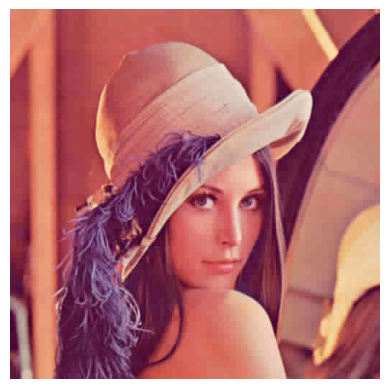

In [29]:
image_with_padding = np.zeros((padded_image.shape[0],padded_image.shape[1],channels))
num_blocks_h = math.ceil( h / block_size )
num_blocks_w = math.ceil( w / block_size )
index = 0
#print(my_blocks[0:64])
# Now we must prepare the compressed image
for channel in range( channels ):
    index = 0
    for index1 in range(num_blocks_h):
        row_begin = index1 * 8
        row_end = row_begin + 8
        
        for index2 in range(num_blocks_w):
            column_begin = index2 * 8
            column_end = column_begin + 8
            
            stream_data = my_blocks[index,: ,channel]
            index += 1
            block = inverseZigZag( stream_data ) # getting 8x8 block 
            de_quantized = np.multiply(block,Q[channel])
            image_with_padding[row_begin:row_end ,column_begin : column_end,channel] = cv2.idct(de_quantized)
        
# converting to rgb
image_with_padding[image_with_padding>255] = 255
image_with_padding[image_with_padding<0] = 0

plt.axis("off")
plt.imshow(np.uint8(ycbcr_to_rgb( image_with_padding ) ))